# Pre-processing

Before we analyze the dataset we will perform some cleaning.

In [1]:
# Import's
import numpy as np
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# 1. Cleaning

## 1.1 UserList

In [2]:
# Reading data
userList = pd.read_csv('UserList.csv')

We will drop two columns in userList:

- user_id: username it's an unique identifier two and it's used on another databases. So it's not necessary this column.
- acess_rank: Every sample has NA values in this column.
- last_online: For our analysis we don't will use this column.

In [3]:
# Check amount
userList.shape

(302675, 17)

In [4]:
# Cols to drop
drop_cols = ['user_id','access_rank','last_online']
userList = userList.drop(columns = drop_cols)

In [5]:
# Check for NA values
userList.isna().sum()

username                         1
user_watching                    0
user_completed                   0
user_onhold                      0
user_dropped                     0
user_plantowatch                 0
user_days_spent_watching         0
gender                       84875
location                    145901
birth_date                  133926
join_date                      129
stats_mean_score               129
stats_rewatched                129
stats_episodes                 129
dtype: int64

In [6]:
# We can't do anything with gender and username so we will just delete rows without value
userList = userList.dropna(subset=['gender','username'])

In [8]:
# Check unique values
userList['gender'].unique()

array(['Female', 'Male', 'Non-Binary'], dtype=object)

In [12]:
# Remove rows with non-binary
userList = userList[~userList['gender'].map(lambda x: x=='Non-Binary')]

I prefer delete these rows than impute some value because I think doing this will disrupt our analyzes.

In [13]:
# If you check column location, you will notice that we have many wrong values
userList['location'].unique()[:50]

array(['Chennai, India ', 'Manila', 'Detroit,Michigan', 'Nayarit, Mexico',
       'Malaysia, Kuantan', 'Nijmegen, Nederland', nan, 'California',
       'Poland', 'Norberg Sweden', 'Nebraska', 'England,Manchester',
       '~ Hungary ~', 'United Kingdom', 'manila', 'home', 'socal =)',
       'Mexico', 'Hamilton Ontario', 'Nevada USA', 'Chicago, IL',
       'San Jose, CA', 'somewhere really hot', 'Guess',
       'Camaragibe, Pernambuco', 'ａｕｓｔｒｉａ。', 'Canada',
       'Rhineland-Palatinate, Germany', 'Philadelphia PA',
       'The Crimson World (England :P)', 'Carbonear, Newfoundland',
       'Shiraz', 'Romania', 'SC, Brasil', 'Vienna, Austria', 'ROSTOV',
       'Parana, Brasil', 'Santa Barbar, California', 'Salisbury NC',
       'Kemerovo, Russia', 'Starlight Breaker', 'India',
       'Sofia, Bulgaria', 'New South Wales', 'Buenos Aires, Argentina',
       'Cairo, Egypt', 'Pelotas,Brasil', 'Chester, California',
       'Justinside a Reality Marble', '014'], dtype=object)

In [14]:
'''

Get all countries's names

'''
def get_countries():
    # Request to website
    page = requests.get('https://www.britannica.com/topic/list-of-countries-1993160')

    # Parsing the page
    soup = BeautifulSoup(page.text,'html.parser')

    # Get all countries (exclude two first lines because don't have information)
    all_countries = soup.find_all(class_='md-crosslink')[2:]

    # Get all countries's name
    return [x.get_text().lower() for x in all_countries]

Let's try to normalize the column location. To do this we will get all countries name and compare with our column. Values that don't match will be consider like 'unknown'.

In [15]:
# Get all countries
all_countries = get_countries()

In [16]:
# Transform all values to lower
userList['location'] = userList['location'].map(lambda x: 'unknown' if type(x) == float else x.lower())

/home/sugi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
'''

Check with row has some country.
If we find more than 1 ou 0 contry
thr return value will be unknown

'''
def check_country(x):
        # Check if exist country
        country = [country for country in all_countries if country in x]
        
        # Check if it's one or not
        if(len(country) != 1):
            return 'unknown'
        return country[0]

In [18]:
# Check countries
userList['location'] = userList['location'].map(lambda x: check_country(x))

/home/sugi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We were able to normalize the column location. But as you can see below we have many countries unknown. Because of this we will exclude such lines as well.

In [19]:
# Delete unknown countries
userList = userList[userList['location'] != 'unknown']

Now let's tranform column birth_date to age.

In [20]:
# Creating column age
userList['age'] = userList['birth_date'].map(lambda x: x if type(x) == float else 2019-int(x.split('-')[0]))

# Delete column birth_date
del userList['birth_date']

We will fill na values with median. In general this aproach it's better than mean and mode.

In [21]:
# Fill na with median
userList['age'] = userList['age'].fillna(userList['age'].median())

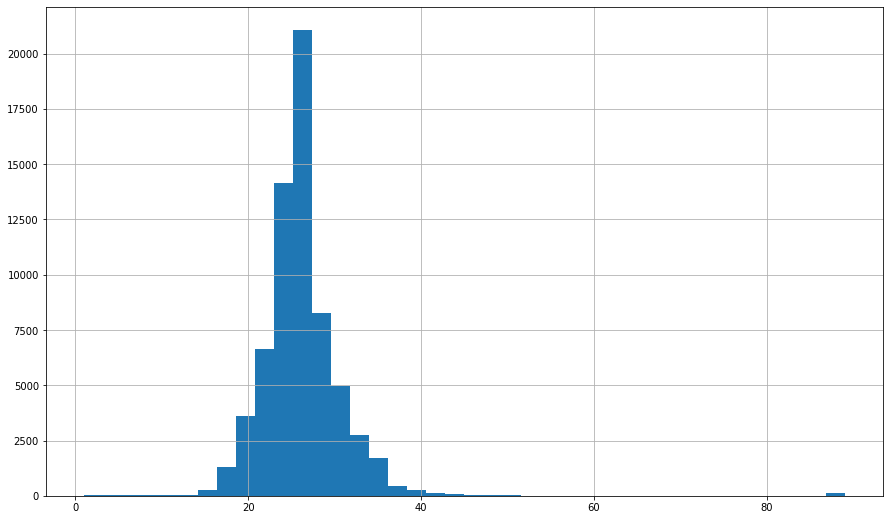

In [22]:
# Plot histogram about age
plt.figure(figsize=(15,9))
userList['age'][userList['age']>0].hist(bins=40)

You can see in the histogram above that our data seems to be more or less normaly. Because of it we will truncate values in the following way:

- Values less than Q1-1.5(IQR) will be truncate to Q1-1.5(IQR)
- Values more than Q3+1.5(IQR) will be truncate to Q3+1.5(IQR)

Where Q1 and Q3 are first and third quartile and IQR is Q3-Q1.

In [23]:
# Computing values
Q3 = userList['age'].quantile(q=0.75)
Q1 = userList['age'].quantile(q=0.25)
IQR = Q3-Q1
factor = 1.5*(IQR)

In [24]:
# Truncating values
userList['age'] = userList['age'].map(lambda x: Q3+factor if x > Q3+factor else x)
userList['age'] = userList['age'].map(lambda x: Q1-factor if x < Q1-factor else x)

In [25]:
# Let's salve the new data
userList.to_csv('UserListCleaned.csv',index=False)

## 1.2 AnimeList

In [20]:
# Reading data
animeList = pd.read_csv('AnimeList.csv')

In [21]:
# Discard animes that are not aired yet
animeList = animeList[animeList['status'] != 'Not yet aired']

# Columns to drop
drop_cols = ['title_english','title_japanese','title_synonyms','image_url','status','aired_string','background','producer','opening_theme','ending_theme','broadcast','related']

# Drop cols
animeList = animeList.drop(columns=drop_cols)

We discard animes that are not yet aired because the don't have much information for us. Beyond this, other columns are exclude becase some of them have the same information in another columns or don't have anything to add in our analysis.

In [22]:
# Check for na values
animeList.isna().sum()

anime_id          0
title             0
type              0
source            0
episodes          0
airing            0
aired             0
duration          0
rating            0
score             0
scored_by         0
rank           1244
popularity        0
members           0
favorites         0
premiered     10117
licensor      10783
studio         5754
genre            56
dtype: int64

In [23]:
# In rank, licensor and studio it's not possible imput values, so let's drop rows without this information
animeList = animeList.dropna(subset=['rank','licensor','studio'])

In [24]:
# In premiered first we will exclude None information on aired

# Regular expression
exp = re.compile('.*None,.*')

# Delete rows
animeList = animeList[animeList['aired'].map(lambda x: False if exp.match(x) else True)]

In column aired we have the month that anime start airing. So with these we can fill column premiered using these rules:

- from 12 to 3: Winter
- from 3 to 6: Spring
- from 6 to 9: Summer
- from 9 to 12: Fall

Before we do this, let's transform both columns.

In [25]:
# Delete year
animeList['premiered'] = animeList['premiered'].map(lambda x: x if type(x) == float else x.split(' ')[0])

In [26]:
# Regular expression to extract dates
exp = re.compile('[0-9]{4}-[0-9]{2}-[0-9]{2}')

# We just will store the start aired
animeList['aired'] = animeList['aired'].map(lambda x: exp.findall(x)[0])

# Convert to datetime
animeList['aired'] = pd.to_datetime(animeList['aired'])

In [27]:
'''

Get the correct premiered

'''
def get_premiered(x):
    if(x.month>3 and x.month<=6):
        return 'Sprint'
    if(x.month>=6 and x.month<=9):
        return 'Summer'
    if(x.month>=9 and x.month<=12):
        return 'Fall'
    else:
        return 'Winter'

In [28]:
# Get temporary premiered
tmp_premiered = animeList['aired'].apply(get_premiered)

# Get index from values that are NA
index = animeList.loc[animeList['premiered'].isna(),'premiered'].index

# Fill na
animeList.loc[animeList['premiered'].isna(),'premiered'] = tmp_premiered[index].values

Now we will fix column duration.

In [29]:
# Regular expression
exp = re.compile('^[0-9]{1,2} min.*')

# First transformation where duration just has min
animeList['duration'] = animeList['duration'].map(lambda x: x.split(' ')[0] if exp.match(x) else x)

In [30]:
# Delete rows that have seconds of episode and unknown
animeList = animeList[animeList['duration'] != 'Unknown']
animeList = animeList[~animeList['duration'].map(lambda x: 'sec' in x)]

In [31]:
'''

Convert hour to min

'''
def transform_hour_to_min(x):
    if(len(x.split('. '))>1):
        hour = (int(x.split(' ')[0]) * 60)
        try:
            min_ = int(x.split('. ')[1].split(' ')[0])
        except:
            min_ = 0
        return str(hour + min_)
    else:
        return str(int(x.split(' ')[0]) * 60)

In [32]:
# Regular expression
exp = re.compile('^[0-9] hr.*')

# Second transformation where duration has hr
animeList['duration'] = animeList['duration'].map(lambda x: transform_hour_to_min(x) if exp.match(x) else x).astype(int)

Columns genre, licensor and studio sometimes have more than one value. Because of it, first we will just normalize them.

In [33]:
# Normalizing
animeList['genre'] = animeList['genre'].map(lambda x: x.lower().replace(' ',''))
animeList['licensor'] = animeList['licensor'].map(lambda x: x.lower())
animeList['studio'] = animeList['studio'].map(lambda x: x.lower())

Now, we will take just the top 20 most popular studios and licensor. The left will be considery like others. This aproach it's valid because a lot of studios and licensors with just some values. So it's better consider just the top.

In [34]:
# Top 20 licensor
top_licensor = animeList.groupby('licensor').size().sort_values(ascending=False)[:20].index.values
animeList.loc[~animeList['licensor'].isin(top_licensor),'licensor'] = 'others'

# Top 20 studio
top_studio = animeList.groupby('studio').size().sort_values(ascending=False)[:20].index.values
animeList.loc[~animeList['studio'].isin(top_studio),'studio'] = 'others'

In [35]:
# Our data is done, so let's sabe them
animeList.to_csv('AnimeListCleaned.csv',index=False)

## 1.3 UserAnimeList

The others datasets have few data so it's possible to use pandas. But now, in dataset UserAnimeList we have approximately 5 GB which makes it impossible to perform the analyzes (my machine has only 8GM of ram).Because of this we will use the Spark framework to perform the processing. 

In [36]:
# Creating spark session
sp = SparkSession.builder.master('local').appName('MAL').getOrCreate()

In [37]:
# Reading data
userAnimeList = sp.read.csv('UserAnimeList.csv',header=True)

In [38]:
# Number of samples
nrow = userAnimeList.count()

In [39]:
# Columns in dataset
userAnimeList.printSchema()

root
 |-- username: string (nullable = true)
 |-- anime_id: string (nullable = true)
 |-- my_watched_episodes: string (nullable = true)
 |-- my_start_date: string (nullable = true)
 |-- my_finish_date: string (nullable = true)
 |-- my_score: string (nullable = true)
 |-- my_status: string (nullable = true)
 |-- my_rewatching: string (nullable = true)
 |-- my_rewatching_ep: string (nullable = true)
 |-- my_last_updated: string (nullable = true)
 |-- my_tags: string (nullable = true)



Again we will delete some columns because it's not interesting for our analysis:

- my_start_date
- my_finish_date
- my_last_updated
- my_tags

In [40]:
# Cols to drop
drop_cols = ['my_start_date','my_finish_date','my_last_updated','my_tags']
userAnimeList = userAnimeList.drop(*drop_cols)

In [41]:
# Schema
userAnimeList.printSchema()

root
 |-- username: string (nullable = true)
 |-- anime_id: string (nullable = true)
 |-- my_watched_episodes: string (nullable = true)
 |-- my_score: string (nullable = true)
 |-- my_status: string (nullable = true)
 |-- my_rewatching: string (nullable = true)
 |-- my_rewatching_ep: string (nullable = true)



In [42]:
# Show some rows
userAnimeList.take(100)

[Row(username='karthiga', anime_id='21', my_watched_episodes='586', my_score='9', my_status='1', my_rewatching=None, my_rewatching_ep='0'),
 Row(username='karthiga', anime_id='59', my_watched_episodes='26', my_score='7', my_status='2', my_rewatching=None, my_rewatching_ep='0'),
 Row(username='karthiga', anime_id='74', my_watched_episodes='26', my_score='7', my_status='2', my_rewatching=None, my_rewatching_ep='0'),
 Row(username='karthiga', anime_id='120', my_watched_episodes='26', my_score='7', my_status='2', my_rewatching=None, my_rewatching_ep='0'),
 Row(username='karthiga', anime_id='178', my_watched_episodes='26', my_score='7', my_status='2', my_rewatching='0', my_rewatching_ep='0'),
 Row(username='karthiga', anime_id='210', my_watched_episodes='161', my_score='7', my_status='2', my_rewatching=None, my_rewatching_ep='0'),
 Row(username='karthiga', anime_id='232', my_watched_episodes='70', my_score='6', my_status='2', my_rewatching=None, my_rewatching_ep='0'),
 Row(username='karthig

You can see above that columns my_rewatching and my_rewatching_ep have a lot of values None and 0, consecutively. Because of this let's explore these two columns.

In [43]:
# Compute some statistics
statistics = userAnimeList.describe(['my_rewatching','my_rewatching_ep'])

In [44]:
# Show statistics
statistics = statistics.toPandas()
statistics

,summary,my_rewatching,my_rewatching_ep
0,count,63334578,80076306
1,mean,9.482069093769412E-4,7.4066751407698
2,stddev,0.6655954555573731,11109.72805140888
3,min,,
4,max,Świat alternatywny,paralk


In [45]:
# Percentage of na values - my_rewatching
1-(int(statistics['my_rewatching'][0])/nrow)

0.2112601296493496

In [46]:
# Percentage of na values - my_rewatching_ep
1-(int(statistics['my_rewatching_ep'][0])/nrow)

0.00276630543588674

So the column my_rewatching have almost approximately 20% of Na values and most of valid values are 0 (check the mean and stddev). So I don't think this column has a lot of information. It's better drop.

Column my_rewatching_ep has strange values. His mean and stddev it's 7.4, ~11109. That's values it's very strange for watch episodes so let's explore them more.

In [47]:
# Drop column
userAnimeList = userAnimeList.drop('my_rewatching')

In [48]:
# Change type
userAnimeList = userAnimeList.withColumn('my_rewatching_ep',userAnimeList['my_rewatching_ep'].cast('int'))

In [49]:
# Verify what values are different from 0
my_rewatching_ep = userAnimeList.select('my_rewatching_ep').filter(userAnimeList['my_rewatching_ep'] != 0)

In [50]:
# Verify how many samples we have
my_rewatching_ep.count()

11967

We have 11967 samples (it's not too big) so it's possible convert this data to pandas.

In [51]:
# Convert to pandas
my_rewatching_ep = my_rewatching_ep.toPandas()

In [52]:
# Show samples with more than 300
my_rewatching_ep[my_rewatching_ep['my_rewatching_ep'] > 300]

,my_rewatching_ep
1290,305
2416,315
2430,345
4697,653
6987,690
7005,366
7034,429
7919,343
9535,407
9857,2011


In [53]:
# Percentage of values that are not 0
(my_rewatching_ep.shape[0]/nrow) * 100

0.01490315452719403

We can see that there are some really very strange values like 16777215, possibly it's a purposed user error. Beyond it, there are other reasonably high values for this column that do not make much sense.

In addition, the valid values (different from zero) are only ~ 0.014% of the total, that is, there are few values for analysis.

Again, I believe that this column does not have enough information for the analyzes, so we will exclude them.

After that, our pre-processing is finished. Just save the dataset now.

In [54]:
# Drop column
userAnimeList = userAnimeList.drop('my_rewatching_ep')

In [55]:
# Save new data
userAnimeList.repartition(1).write.csv('UserAnimeListCleaned',header=True)